In [1]:
# Importing needed libraries

import torch, os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import grad
from helpers import *
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from CGDs import ACGD

c:\Users\dange\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Impossibile trovare la procedura specificata
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class Generator(nn.Module):
    
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(Generator, self).__init__()
        self.input_dim = input_dim 
        self.output_dim = output_dim 
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        # The following layers are used to upsample the input
        # noise and generate an output image.
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        # This function initializes the weights and biases of the 
        # generator's layers:
        initialize_weights(self) 

    def forward(self, input):
        '''
        The input to the forward method represents the input noise 
        to the generator model. It returns the generated output image.
        '''
        
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4)) # Reshapes x to match the expected size for the subsequent transposed convolutional layers. 
        x = self.deconv(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            # nn.Sigmoid(),
        )
        
        # This function initializes the weights and biases of the 
        # discriminator's layers:
        initialize_weights(self)

    def forward(self, input):
        '''
        The input to the forward method represents the input image
        It returns the output prediction, which represents the discriminator's assessment of the input image.
        '''
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [4]:
class WGAN(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
        self.epoch = epoch
        self.batch_size = batch_size

        self.save_dir = save_dir
        self.result_dir = result_dir

        self.device = device
        self.dataset = dataset

        self.input_size = input_size    # Default: 32

        self.D_losses = []
        self.G_losses = []
        self.inception_scores = []
        self.frechet_inception_distances = []

        self.model_name = 'WGAN'        
        self.z_dim = 62                 # Represents the dimensionality of the (Gaussian) random input vector used by the generator.
        self.d_param_max = 0.01         # Clipping value
        self.iteration_g_per_d = 5      # Specifies the number of iterations of the generator per discriminator iteration. 
                                        # This controls the relative training frequency of the generator and discriminator.

        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)        
        
        if self.dataset == 'cifar10':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(),
                                        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        
        data = self.data_loader.__iter__().__next__()[0]

        # Initialize generator, discriminator and optimizers
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda:0':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda:0':
            self.sample_z = self.sample_z.cuda()

        print('---------------INITIALIZATION-----------------')
        print('|           Model: WGAN with Adam            |')
        print('----------------------------------------------')


    def train(self):
        self.y_real = torch.ones(self.batch_size, 1) # Initialize labels for real samples (i.e. 1)
        self.y_fake = torch.zeros(self.batch_size, 1) # Initialize labels for fake samples (i.e. 0)

        if self.device == 'cuda:0':
            self.y_real = self.y_real.cuda()
            self.y_fake = self.y_fake.cuda()

        self.D.train() #D network in train mode

        print('Start training!')
        tot_iter = 0
        for epoch in range(self.epoch):
            iteration_losses_G = []     # Auxiliary arrays to compute the mean loss for each epoch
            iteration_losses_D = []

            self.G.train() #G network in train mode

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == (self.data_loader.dataset.__len__() // self.batch_size): # Exit the loop when it has been used the whole dataset
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))

                if self.device == 'cuda:0':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # PART 1: UPDATE THE DISCRIMINATOR
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train) # Computes the discriminator output for real data
                D_real_loss = -torch.mean(D_real) # Calculates the loss for the discriminator on real data. 
                                                  # The objective is to maximize the average output of the discriminator for real data.

                G_ = self.G(z_noise) # Generates fake data using the generator
                D_fake = self.D(G_) # Computes the discriminator output for fake data.
                D_fake_loss = torch.mean(D_fake) # Calculates the loss for the discriminator on fake data. 
                                                 # The objective is to minimize the average output of the discriminator for fake data.

                D_loss = D_real_loss + D_fake_loss # Calculates the total discriminator loss as the sum of the losses on real and fake data.

                D_loss.backward()
                self.D_optimizer.step()

                # Clipping D parameters to a specified range to enforce Lipschitz continuity.
                for p in self.D.parameters():
                    p.data.clamp_(-self.d_param_max, self.d_param_max)

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # PART 2: UPDATE THE GENERATOR
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake) # Calculates the generator loss as the negative average output of the discriminator for fake data. 
                                                 # The objective is to maximize the average output of the discriminator for the generated fake data.

                    iteration_losses_G.append(G_loss.item())

                    G_loss.backward()

                    self.G_optimizer.step()

                    iteration_losses_D.append(D_loss.item())
                
                if tot_iter % 1000 == 0:        # Compute the Inception scores and the FID scores every 1000 iterations
                     with torch.no_grad():
                        score=self.IS()
                        self.inception_scores.append(score[0].item())
                        distance=self.FID()
                        self.frechet_inception_distances.append(distance.item())
                tot_iter += 1
            
            self.G_losses.append(np.mean(iteration_losses_G))
            self.D_losses.append(np.mean(iteration_losses_D))

            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Discriminator loss: {self.D_losses[-1]}')
            print(f'Generator loss: {self.G_losses[-1]}')

            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished.")
        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        save_scores(self.inception_scores, self.save_dir, self.dataset, self.model_name, IS=True)
        save_scores(self.frechet_inception_distances, self.save_dir, self.dataset, self.model_name, FID=True)
        save_loss(self.G_losses, self.save_dir, self.dataset, self.model_name, Generator=True)
        save_loss(self.D_losses, self.save_dir, self.dataset, self.model_name, Discriminator=True)
    


    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS
        


    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID



    def visualize_results(self, epoch):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)
        
        if self.device == 'cuda:0':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    


    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')
        


In [5]:
class WGAN_GP(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_size = input_size

        self.dataset = dataset

        self.save_dir = save_dir
        self.result_dir = result_dir

        self.device = device

        self.model_name = 'WGAN_GP'
        self.z_dim = 62
        self.lambda_ = 10
        self.iteration_g_per_d = 5

        
        self.G_losses = []
        self.D_losses = []
        self.inception_scores = []
        self.frechet_inception_distances = []

        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)
        
        if self.dataset == 'cifar10':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])           
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)),
                                        transforms.ToTensor(),
                                        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                        transforms.Normalize(mean=(0.5), std=(0.5))
                                        ])
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
                
        data = self.data_loader.__iter__().__next__()[0]

        # Initialization of optimizers and of generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda:0':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda:0':
            self.sample_z = self.sample_z.cuda()
        
        print('---------------INITIALIZATION-----------------')
        print('| Model: WGAN with Adam and Gradient Penalty |')
        print('----------------------------------------------')


    def train(self):    
        self.y_real = torch.ones(self.batch_size, 1)
        self.y_fake = torch.zeros(self.batch_size, 1)

        if self.device == 'cuda:0':
            self.y_real = self.y_real.cuda()
            self.y_fake =  self.y_fake.cuda()

        self.D.train() #Discriminator in train mode

        print('Start training!')
        tot_iter = 0
        for epoch in range(self.epoch):
            iteration_losses_G = []                                                  # Auxiliary arrays to compute the mean loss for each epoch
            iteration_losses_D = []
            
            self.G.train()                                                           # Generator in train mode

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:    # Exit the loop when it has been used the whole dataset
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))
                if self.device == 'cuda:0':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # PART 1: UPDATE THE DISCRIMINATOR
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_noise)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                # Gradient penalty
                alpha = torch.rand((self.batch_size, 1, 1, 1))
                if self.device == 'cuda:0':
                    alpha = alpha.cuda()

                x_hat = alpha * x_train.data + (1 - alpha) * G_.data
                x_hat.requires_grad = True

                pred_hat = self.D(x_hat)
                if self.device == 'cuda:0':
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
                else:
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()),
                                     create_graph=True, retain_graph=True, only_inputs=True)[0]

                gradient_penalty = self.lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

                D_loss = D_real_loss + D_fake_loss + gradient_penalty # Loss with gradient penalty

                D_loss.backward()
                self.D_optimizer.step()

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # PART 2: UPDATE THE GENERATOR
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)

                    iteration_losses_G.append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    iteration_losses_D.append(D_loss.item())
                
                if tot_iter%1000 == 0:
                    with torch.no_grad():
                        score=self.IS()
                        self.inception_scores.append(score[0].item())
                        distance=self.FID()
                        self.frechet_inception_distances.append(distance.item())
                tot_iter += 1

            self.G_losses.append(np.mean(iteration_losses_G))
            self.D_losses.append(np.mean(iteration_losses_D))

            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Average Discriminator loss: {self.D_losses[-1]}')
            print(f'Average Generator loss: {self.G_losses[-1]}\n')
            
            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished!")

        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        save_scores(self.inception_scores, self.save_dir, self.dataset, self.model_name, IS=True)
        save_scores(self.frechet_inception_distances, self.save_dir, self.dataset, self.model_name, FID=True)
        save_loss(self.G_losses, self.save_dir, self.dataset, self.model_name, Generator=True)
        save_loss(self.D_losses, self.save_dir, self.dataset, self.model_name, Discriminator=True)
    


    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS
    


    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID



    def visualize_results(self, epoch, fix=True):
        '''
        By calling this method during the training loop, you can visualize and save the 
        generated samples at regular intervals to monitor the progress 
        of the generator's output over the course of training.
        '''
        self.G.eval()                           # Set the generator in evaluation mode.

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)         # These samples represent the generator's output at the given epoch        
        
        # The dimensions are transposed to match the image format
        if self.device == 'cuda:0':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)
        samples = (samples + 1) / 2             # Normalizes the samples by scaling their pixel 
                                                # values from the range [-1, 1] to the range [0, 1]
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')



    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')


In [6]:
class WGAN_ACGD(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD):
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_size = input_size

        self.dataset = dataset

        self.save_dir = save_dir
        self.result_dir = result_dir
        
        self.device = device

        self.model_name = 'WGAN_ACGD'
        self.z_dim = 62
        self.lambda_ = 10
        self.d_param_max = 0.01

        
        self.losses = []
        self.inception_scores = []
        self.frechet_inception_distances = []
        
        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)               
        
        if self.dataset == 'cifar10':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(),
                                        transforms.Lambda(lambda x: x.repeat(3, 1, 1)), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        
        data = self.data_loader.__iter__().__next__()[0]

        # Initialization of optimizers and of generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.optimizer = ACGD(max_params=self.G.parameters(), min_params=self.D.parameters(), lr_max=lrG, lr_min=lrD)
        

        if self.device == 'cuda:0':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda:0':
            self.sample_z = self.sample_z.cuda()

        print('----------------------INITIALIZATION------------------------')
        print('| Model: WGAN using Competitive Gradient Descent optimizer |')
        print('------------------------------------------------------------')
        

    def train(self):
        self.y_real = torch.ones(self.batch_size, 1)    # Initialize labels for real samples (i.e. 1)
        self.y_fake = torch.zeros(self.batch_size, 1)   # Initialize labels for fake samples (i.e. 0)

        if self.device == 'cuda:0':
            self.y_real = self.y_real.cuda()
            self.y_fake = self.y_fake.cuda()

        self.D.train()                                  #D network in train mode

        print('Start training!')
        tot_iter = 0
        for epoch in range(self.epoch):
            self.G.train()                              # G network in train mode
            iteration_losses = []                       # Auxilary array to compute the mean loss for each epoch
            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))

                if self.device == 'cuda:0':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # UPDATE NETWORKS
                self.optimizer.zero_grad()

                D_real = self.D(x_train)                # Computes the discriminator output for real data
                D_real_loss = -torch.mean(D_real)       # Calculates the loss for the discriminator on real data. 
                                                        # The objective is to maximize the average output of the discriminator for real data.

                G_ = self.G(z_noise)                    # Generates fake data using the generator
                D_fake = self.D(G_)                     # Computes the discriminator output for fake data.
                D_fake_loss = torch.mean(D_fake)        # Calculates the loss for the discriminator on fake data. 
                                                        # The objective is to minimize the average output of the discriminator for fake data.

                loss = D_real_loss + D_fake_loss        # Calculates the total discriminator loss as the sum of the losses on real and fake data.
                
                iteration_losses.append(loss.detach().cpu())
                self.optimizer.step(loss=loss)

                # Clipping D parameters to a specified range to enforce Lipschitz continuity.
                for p in self.D.parameters():
                    p.data.clamp_(-self.d_param_max, self.d_param_max)
                
                if tot_iter%1000 == 0:
                    with torch.no_grad():
                        score=self.IS()
                        self.inception_scores.append(score[0].item())
                        distance=self.FID()
                        self.frechet_inception_distances.append(distance.item())
                tot_iter += 1

            self.losses.append(np.mean(iteration_losses))

            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Average loss: {self.losses[-1]}')

            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished.")

        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot_ACGD(self.losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        save_scores(self.inception_scores, self.save_dir, self.dataset, self.model_name, IS=True)
        save_scores(self.frechet_inception_distances, self.save_dir, self.dataset, self.model_name, FID=True)
        save_loss(self.losses, self.save_dir, self.dataset, self.model_name)


    def visualize_results(self, epoch):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)
        if self.device == 'cuda:0':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    


    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS



    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID
    

    def save_scores_loss(self):
        save_scores


    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')

In [7]:
# PARAMETERS

# Define dataset ['cifar10', 'mnist']
dataset = 'mnist'

# Define WGAN type [WGAN, WGAN_GP, WGAN_ACGD]
gan_type = 'WGAN'

# Define number of epoch
epoch = 100

# Define batch_size
batch_size = 64

# Define input_size
input_size = 32

# Define directory for saving results and models
save_dir = 'models'
result_dir = 'results'


# Defining learning rates
lrG = 0.0001        # Generator
lrD = 0.0001        # Discriminator

# Adam beta parameters
beta1 = 0.5
beta2 = 0.9

# 'cuda' if GPU is available, 'cpu' else
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

if gan_type == 'WGAN':
    wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
elif gan_type == 'WGAN_GP':
    wgan = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
elif gan_type == 'WGAN_ACGD':
    wgan = WGAN_ACGD(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD)


c:\Users\dange\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


---------------INITIALIZATION-----------------
|           Model: WGAN with Adam            |
----------------------------------------------


Start training!
Epoch: 1/100
Discriminator loss: -0.01956271329511176
Generator loss: 0.006408452012770396


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 2/100
Discriminator loss: -0.016585889282352464
Generator loss: 0.004360799583043644


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 3/100
Discriminator loss: -0.015800796877493195
Generator loss: 0.004097081704954194


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 4/100
Discriminator loss: -0.0161630479708553
Generator loss: 0.004198588783240175


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 5/100
Discriminator loss: -0.01737032300309542
Generator loss: 0.004697142976938802


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 6/100
Discriminator loss: -0.018090481172629538
Generator loss: 0.005579996099546154


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 7/100
Discriminator loss: -0.021980407453555475
Generator loss: 0.007686821303086325


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 8/100
Discriminator loss: -0.020893300893432633
Generator loss: 0.007201207238921826


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 9/100
Discriminator loss: -0.02483515508154178
Generator loss: 0.009670253305192937


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 10/100
Discriminator loss: -0.025156681211715076
Generator loss: 0.009736767217995011


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 11/100
Discriminator loss: -0.025322375181604198
Generator loss: 0.009792704214864873


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 12/100
Discriminator loss: -0.025306525615287973
Generator loss: 0.009601666009362369


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 13/100
Discriminator loss: -0.025320223955945534
Generator loss: 0.009606049610252049


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 14/100
Discriminator loss: -0.025464813110423597
Generator loss: 0.009653584349322765


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 15/100
Discriminator loss: -0.025498731390518302
Generator loss: 0.009804885406146713


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 16/100
Discriminator loss: -0.02516346595145483
Generator loss: 0.009539753233486


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 17/100
Discriminator loss: -0.02286775577514567
Generator loss: 0.007482806031397957


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 18/100
Discriminator loss: -0.02382162711358963
Generator loss: 0.008217065552757545


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 19/100
Discriminator loss: -0.022225467000096876
Generator loss: 0.008091598549947381


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 20/100
Discriminator loss: -0.020215844785306542
Generator loss: 0.00748542272535596


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 21/100
Discriminator loss: -0.020317002503390618
Generator loss: 0.00753474531491053


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 22/100
Discriminator loss: -0.020806695628453067
Generator loss: 0.00774980615824461


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 23/100
Discriminator loss: -0.02069750349510481
Generator loss: 0.007661659200800294


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 24/100
Discriminator loss: -0.020978761209364243
Generator loss: 0.007802403225678014


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 25/100
Discriminator loss: -0.021026910945055956
Generator loss: 0.007725638815545462


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 26/100
Discriminator loss: -0.021160122325872992
Generator loss: 0.007666190139909479


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 27/100
Discriminator loss: -0.020916888998313385
Generator loss: 0.0074173303814057045


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 28/100
Discriminator loss: -0.02079556063614427
Generator loss: 0.007363465211209766


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 29/100
Discriminator loss: -0.020724092655003388
Generator loss: 0.007285813596796862


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 30/100
Discriminator loss: -0.020859274813995004
Generator loss: 0.0073889540657799515


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 31/100
Discriminator loss: -0.020731763246862645
Generator loss: 0.007318979918578251


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 32/100
Discriminator loss: -0.020575605372694088
Generator loss: 0.0071837194164328395


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 33/100
Discriminator loss: -0.020269591958924412
Generator loss: 0.00696158575212812


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 34/100
Discriminator loss: -0.020561402469355474
Generator loss: 0.007064299948045356


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 35/100
Discriminator loss: -0.020256066396035614
Generator loss: 0.006877491858235017


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 36/100
Discriminator loss: -0.020689892896356428
Generator loss: 0.007119027968685337


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 37/100
Discriminator loss: -0.020552227492718136
Generator loss: 0.00702985332292669


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 38/100
Discriminator loss: -0.020795500453780678
Generator loss: 0.007164038969253633


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 39/100
Discriminator loss: -0.02125128489087291
Generator loss: 0.007417374043999349


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 40/100
Discriminator loss: -0.02067565139044415
Generator loss: 0.0070519009256426665


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 41/100
Discriminator loss: -0.02075593687474409
Generator loss: 0.007068370446503003


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 42/100
Discriminator loss: -0.02155167519807178
Generator loss: 0.007425115792389541


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 43/100
Discriminator loss: -0.020564179603548293
Generator loss: 0.00701011923505342


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 44/100
Discriminator loss: -0.02054030229063595
Generator loss: 0.0069938180644443645


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 45/100
Discriminator loss: -0.02034486545359387
Generator loss: 0.006985626996489849


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 46/100
Discriminator loss: -0.020347055909348363
Generator loss: 0.006911238715211976


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 47/100
Discriminator loss: -0.02016709914759678
Generator loss: 0.0068230190137550635


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 48/100
Discriminator loss: -0.020293605987002507
Generator loss: 0.006831873056384172


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 49/100
Discriminator loss: -0.020542814072600023
Generator loss: 0.006872082954611291


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 50/100
Discriminator loss: -0.019738231232778274
Generator loss: 0.006573422457076569


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 51/100
Discriminator loss: -0.020172881540209853
Generator loss: 0.0067909572567332556


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 52/100
Discriminator loss: -0.022912463292798255
Generator loss: 0.007846161887487945


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 53/100
Discriminator loss: -0.019021123577965135
Generator loss: 0.006214524191750692


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 54/100
Discriminator loss: -0.022110397006101148
Generator loss: 0.007551320903202429


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 55/100
Discriminator loss: -0.01946679725346559
Generator loss: 0.006376795973417095


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 56/100
Discriminator loss: -0.01986034712530075
Generator loss: 0.006628232385544853


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 57/100
Discriminator loss: -0.02007104550055004
Generator loss: 0.00668591944709978


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 58/100
Discriminator loss: -0.02060185008268943
Generator loss: 0.0069763606892311


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 59/100
Discriminator loss: -0.02046755041907178
Generator loss: 0.006911326321788172


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 60/100
Discriminator loss: -0.020092907227217197
Generator loss: 0.006919813968669523


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 61/100
Discriminator loss: -0.01983294498553888
Generator loss: 0.006796318518475973


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 62/100
Discriminator loss: -0.02005235952409831
Generator loss: 0.006903765685756735


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 63/100
Discriminator loss: -0.019934454091132325
Generator loss: 0.006818194769043973


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 64/100
Discriminator loss: -0.019899325206238317
Generator loss: 0.006688058460977944


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 65/100
Discriminator loss: -0.020110236929062216
Generator loss: 0.006698241980278237


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 66/100
Discriminator loss: -0.02042964092869172
Generator loss: 0.006958598181366283


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 67/100
Discriminator loss: -0.020087506183806586
Generator loss: 0.006763155234698704


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 68/100
Discriminator loss: -0.019885163216348638
Generator loss: 0.006656144359671974


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 69/100
Discriminator loss: -0.019718646126634935
Generator loss: 0.006515611392660017


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 70/100
Discriminator loss: -0.020839752410264575
Generator loss: 0.006955359199577395


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 71/100
Discriminator loss: -0.019654081098456434
Generator loss: 0.006344640956205481


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 72/100
Discriminator loss: -0.01967179518750804
Generator loss: 0.006722787189058322


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 73/100
Discriminator loss: -0.019599285942905727
Generator loss: 0.00647261990906601


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 74/100
Discriminator loss: -0.019791211016515996
Generator loss: 0.00662301293758546


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 75/100
Discriminator loss: -0.019497085596748533
Generator loss: 0.006284183314578099


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 76/100
Discriminator loss: -0.01942484776046187
Generator loss: 0.006498577978392256


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 77/100
Discriminator loss: -0.019207400623410142
Generator loss: 0.006342543272879274


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 78/100
Discriminator loss: -0.019676773863680223
Generator loss: 0.006594416396542986


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 79/100
Discriminator loss: -0.019413360454301466
Generator loss: 0.006381782904805187


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 80/100
Discriminator loss: -0.019726911788796358
Generator loss: 0.006514278868024043


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 81/100
Discriminator loss: -0.020402403379028492
Generator loss: 0.00681241259058529


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 82/100
Discriminator loss: -0.019731928684056443
Generator loss: 0.006497364085327017


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 83/100
Discriminator loss: -0.01953334976884133
Generator loss: 0.006303575653134582


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 84/100
Discriminator loss: -0.019628045383223238
Generator loss: 0.006458470736067483


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 85/100
Discriminator loss: -0.020392114236791502
Generator loss: 0.0068734664654229735


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 86/100
Discriminator loss: -0.019768174229697746
Generator loss: 0.006697273702375631


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 87/100
Discriminator loss: -0.0193707382625198
Generator loss: 0.006355446056129142


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 88/100
Discriminator loss: -0.019263490865176373
Generator loss: 0.006322099483586888


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 89/100
Discriminator loss: -0.019533641058652795
Generator loss: 0.006540847810254218


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 90/100
Discriminator loss: -0.019245777194472877
Generator loss: 0.006359281664574768


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 91/100
Discriminator loss: -0.019680118636492102
Generator loss: 0.006596321517721137


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 92/100
Discriminator loss: -0.01977003038049063
Generator loss: 0.006702584858216783


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 93/100
Discriminator loss: -0.01960476550627201
Generator loss: 0.006482679503944946


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 94/100
Discriminator loss: -0.01938668175296669
Generator loss: 0.006361719686537981


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 95/100
Discriminator loss: -0.019243691495076858
Generator loss: 0.00658291992532179


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 96/100
Discriminator loss: -0.019187876645893973
Generator loss: 0.006426478850650277


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 97/100
Discriminator loss: -0.019246127202429554
Generator loss: 0.006481227181094853


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 98/100
Discriminator loss: -0.018739040522651875
Generator loss: 0.006030326940269922


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 99/100
Discriminator loss: -0.01888771302360583
Generator loss: 0.006317819443775371


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 100/100
Discriminator loss: -0.0191176372933834
Generator loss: 0.006368634774085672
Training finished.


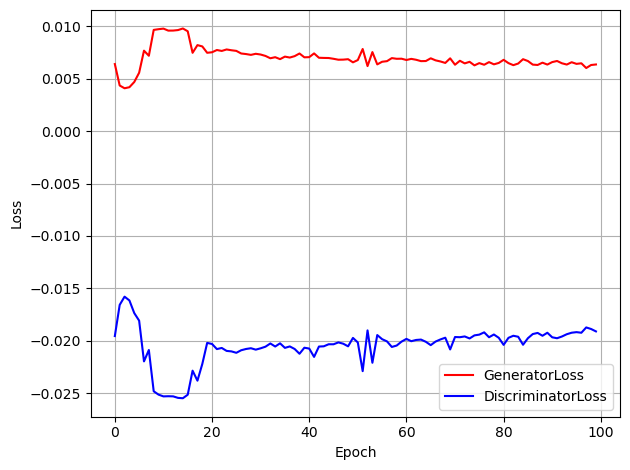

In [8]:
wgan.train()
